In [1]:
# Kernel PCA
## 선형적으로 구분되지 않는 데이터를 선형 분류기에 적합한 저차원 부분공간으로 변환하는 방법

# kernel trick: 원본 특성 공간에서 두 고차원 특성 벡터의 유사도를 계산하는 법

# 일반적으로 사용되는 커널
# (1) 다항 커널
# (2) hyperbolic tangent 커널 (= sigmoid 커널)
# (3) Radial Basis Function 커널 (= RBF 커널, 가우시안 커널)

In [2]:
# RBF 커널 구현

from scipy.spatial.distance import pdist, squareform
from scipy import exp
from scipy.linalg import eigh
import numpy as np

def rbf_kernel_pca(X, gamma, n_components):
    """
    X: {넘파이 ndarray}, shape = [n_samples, n_features]
    gamma: float RBF 커널 튜닝 매개변수
    n_components: int 반환할 주성분 개수
    X_pc: {넘파이 ndarray}, shape = [n_samples, k_features]

    """
    # MxN 차원의 데이터셋에서 샘플 간 유클리디안 거리의 제곱 계산
    sq_dists = pdist(X, 'sqeuclidean')

    # 샘플 간 거리를 정방 대칭 행렬로 변환
    mat_sq_dists = squareform(sq_dists)

    # 커널 유사도 행렬 계산
    K = exp(-gamma * mat_sq_dists)

    # 커널 행렬을 중앙에 맞추기
    N = K.shape[0]
    one_n = np.ones((N, N)) / N
    K = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)

    # 중앙에 맞춰진 커널 행렬의 고윳값과 고유벡터 계산
    # scipy.linalg.eigh 함수는 오름차순으로 값이 반환되기 때문에 뒤집어줌
    eigvals, eigvecs = eigh(K)
    eigvals, eigvecs = eigvals[::-1], eigvecs[:, ::-1]

    # 최상위 k 개의 고유벡터 선택
    X_pc = np.column_stack([eigvecs[:, i]
                            for i in range(n_components)])

    # 투영된 데이터셋 return
    return X_pc

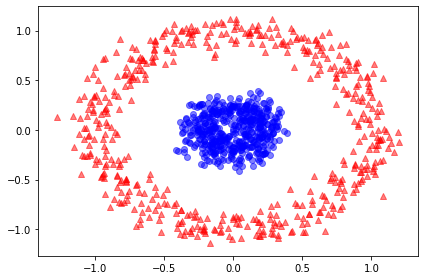

In [5]:
# KPCA로 동심원 데이터 분리하는 방법
## 원본 데이터
from sklearn.datasets import make_circles
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

X, y = make_circles(n_samples=1000, random_state=123, noise=0.1, factor=0.2)

plt.scatter(X[y == 0, 0], X[y == 0, 1], color='red', marker='^', alpha=0.5)
plt.scatter(X[y == 1, 0], X[y == 1, 1], color='blue', marker='o', alpha=0.5)

plt.tight_layout()
plt.show()


/opt/anaconda3/envs/pmlenv/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: scipy.exp is deprecated and will be removed in SciPy 2.0.0, use numpy.exp instead


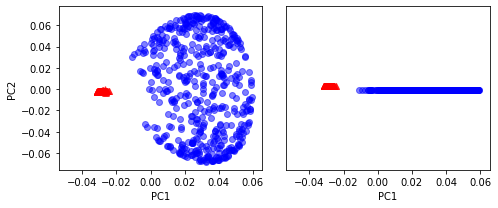

In [6]:
## KPCA에 데이터 투영
X_kpca = rbf_kernel_pca(X, gamma=15, n_components=2)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))
ax[0].scatter(X_kpca[y == 0, 0], X_kpca[y == 0, 1],
              color='red', marker='^', alpha=0.5)
ax[0].scatter(X_kpca[y == 1, 0], X_kpca[y == 1, 1],
              color='blue', marker='o', alpha=0.5)

ax[1].scatter(X_kpca[y == 0, 0], np.zeros((500, 1)) + 0.02,
              color='red', marker='^', alpha=0.5)
ax[1].scatter(X_kpca[y == 1, 0], np.zeros((500, 1)) - 0.02,
              color='blue', marker='o', alpha=0.5)

ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')

plt.tight_layout()
plt.show()

In [7]:
# 훈련되지 않은 새로운 데이터포인트 투영
## 변환행렬 W와 샘플 X 사이 점곱을 굳이 계산하지 않음!
## 새로운 샘플과 훈련 샘플 간 유사도를 계산한 후 고유값으로 고유벡터 정규화
from scipy.spatial.distance import pdist, squareform
from scipy import exp
from scipy.linalg import eigh
import numpy as np

def rbf_kernel_pca(X, gamma, n_components):
    """
    Returns
    ------------
     alphas: {넘파이 ndarray}, shape = [n_samples, k_features] >> 투영된 데이터셋
     lambdas: list >> 고윳값
    """
    sq_dists = pdist(X, 'sqeuclidean')

    mat_sq_dists = squareform(sq_dists)

    K = exp(-gamma * mat_sq_dists)

    N = K.shape[0]
    one_n = np.ones((N, N)) / N
    K = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)

    eigvals, eigvecs = eigh(K)
    eigvals, eigvecs = eigvals[::-1], eigvecs[:, ::-1]

    alphas = np.column_stack([eigvecs[:, i]
                              for i in range(n_components)])

    # (추가된 부분) 고유 벡터에 상응하는 고윳값을 선택
    lambdas = [eigvals[i] for i in range(n_components)]

    return alphas, lambdas

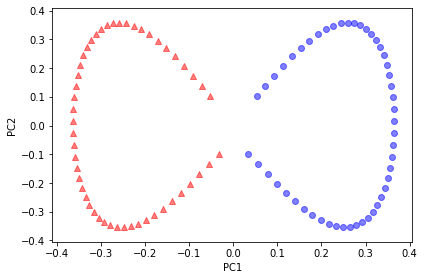

In [10]:
# scikit-learn 내장 KPCA 함수
from sklearn.decomposition import KernelPCA
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=100, random_state=123)
scikit_kpca = KernelPCA(n_components=2, kernel='rbf', gamma=15)
X_skernpca = scikit_kpca.fit_transform(X)

plt.scatter(X_skernpca[y == 0, 0], X_skernpca[y == 0, 1],
            color='red', marker='^', alpha=0.5)
plt.scatter(X_skernpca[y == 1, 0], X_skernpca[y == 1, 1],
            color='blue', marker='o', alpha=0.5)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.tight_layout()
plt.show()

In [8]:
# 요약
## PCA: 클래스 레이블을 사용하지 않고 직교하는 특성 축을 따라 분산이 최대가 되는 저차원 부분 공간으로 데이터 투영
## LDA: 훈련 세트의 클래스 정보를 사용하여 선형 특성 공간에서 클래스 구분 능력 최대화
## KPCA: 커널 트릭과 고차원 특성 공간으로의 가상 투영을 통해 비선형 데이터셋을 저차원 부분 공간으로 압축